# Improved EfficientNet model for ML Use Case 2

In this notebook, we delve into the road damage assessment dataset. Our goal is to train a model for damage severity classification. Specifically, we will set up data paths, load the dataset, and preprocess the data for training. To enhance the performance of the model, we will apply advanced data augmentation techniques and define an improved EfficientNet model, incorporating additional layers and a learning rate scheduler. We will then train the EfficientNet model and evaluate its performance using metrics like classification reports and confusion metrics. Finally, we will visualize sample predictions to understand the model's performance better. 

In [1]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import pandas as pd
import numpy as np
import timm
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Compose, Normalize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### 1. Set Up Data Paths

In [2]:
# Define the paths to the train and test dataset csv files
train_csv_path = "../damage_assessment/train_Dataset_Info.csv"
test_csv_path = "../damage_assessment/test_Dataset_Info.csv"

# Load the train and test dataset from the csv files
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

### 2. Load and preprocess the data

In [3]:
# Define a sequence of transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the images to 224*224 pixels
    transforms.ToTensor(), # Convert the images to Pytorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the images using mean and std deviation for each channel
])

In [4]:
# Define data augmentation and preprocessing for training dataset
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop the image and resize to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8), # Randomly apply color jitter with given probability
    transforms.RandomGrayscale(p=0.2), # Randomly convert the image to grayscale with given probability
    transforms.ToTensor(), # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image with mean and std
])

# Define data preprocessing for testing dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Define a custom dataset class for road damage data
class RoadDamageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_Path'] # Get the image path
        image = Image.open(img_path).convert("RGB") # Open the image and convert to RGB
        label = self.dataframe.iloc[idx]['Severity_Level'] # Get the severity level label
        meta = self.dataframe.iloc[idx]['Number of Potholes'] # Get the number of potholes
        
        if self.transform:
            image = self.transform(image) # Apply the transform to the image
        
        return image, torch.tensor(meta, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [6]:
# Create dataset instances for training and testing data
train_dataset = RoadDamageDataset(train_data, transform=train_transforms)
test_dataset = RoadDamageDataset(test_data, transform=test_transforms)

In [7]:
# Create data loaders for training and testing data
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

### 3. Define the model

In [8]:
# Define the device to be used for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class EfficientNetModel(nn.Module):
    def __init__(self):
        super(EfficientNetModel, self).__init__()
        # Load the pretrained EfficientNet-B0 model
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        # Replace the classifier layer with a new fully connected layer of size 512
        self.efficientnet.classifier = nn.Linear(self.efficientnet.classifier.in_features, 512)
        
        # Additional layers
        self.fc1 = nn.Linear(512 + 1, 256)  # 512 + 1 (meta data input size)
        self.fc2 = nn.Linear(256, 128)  # Additional layer
        self.fc3 = nn.Linear(128, 4) # Final layer for 4 classes
        
        # Activation function and dropout layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, image, meta):
        # Forward pass through the EfficientNet model
        x = self.efficientnet(image)
        # Concatenate image features with meta data
        x = torch.cat((x, meta.unsqueeze(1)), dim=1)
        # Forward pass through additional layers with ReLU activation and dropout
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))  # Additional layer
        x = self.fc3(x)
        return x
    
# Instantiate the model and move it to the appropriate device
efficientnet_model = EfficientNetModel().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)
# Define a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
num_epochs = 50
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    efficientnet_model.train() # Set the model to training mode
    running_loss = 0.0
    print(f"Epoch [{epoch+1}/{num_epochs}] starting...") # Debug information
    for i, (images, metas, labels) in enumerate(train_loader):
        images, metas, labels = images.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad() # Zero the gradients
        outputs = efficientnet_model(images, metas) # Forward pass
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward() # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss / (i+1)}") 
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    scheduler.step()
    # Validation accuracy check
    efficientnet_model.eval() # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, metas, labels in test_loader:
            images, metas, labels = images.to(device), metas.to(device), labels.to(device)
            outputs = efficientnet_model(images, metas)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = efficientnet_model.state_dict()
        torch.save(best_model_wts, 'best_efficientnet_model_2.pth')

print("Finished Training")

Epoch [1/50] starting...
[1, 10] loss: 1.2406595826148987
[1, 20] loss: 1.1470136225223542
[1, 30] loss: 1.087953899304072
[1, 40] loss: 1.0566273093223573
[1, 50] loss: 1.0359856367111206
[1, 60] loss: 1.0297621071338654
[1, 70] loss: 1.0057462751865387
[1, 80] loss: 0.9961016356945038
[1, 90] loss: 0.9812285873625014
[1, 100] loss: 0.9830777502059936
[1, 110] loss: 0.98240600715984
[1, 120] loss: 0.9714694519837698
[1, 130] loss: 0.9776896834373474
[1, 140] loss: 0.9785598235470908
[1, 150] loss: 0.974213490486145
[1, 160] loss: 0.9735978417098522
[1, 170] loss: 0.9676325878676246
[1, 180] loss: 0.9669441819190979
[1, 190] loss: 0.9605942208515971
[1, 200] loss: 0.9573603031039238
[1, 210] loss: 0.955273030201594
[1, 220] loss: 0.9523926775563847
[1, 230] loss: 0.9448866483957871
[1, 240] loss: 0.9383085067073504
Epoch [1/50], Loss: 0.9348109425579916
Validation Loss: 0.7236161935524862, Validation Accuracy: 70.62146892655367%
Epoch [2/50] starting...
[2, 10] loss: 0.8715399205684662

KeyboardInterrupt: 

### 5. Model Evaluation

In [10]:
# Load the saved model
efficientnet_model.load_state_dict(torch.load('best_efficientnet_model_2.pth', map_location=device))

<All keys matched successfully>

Accuracy: 79.04%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       600
           1       0.58      0.70      0.63       251
           2       0.53      0.47      0.50       374
           3       0.84      0.86      0.85       722

    accuracy                           0.79      1947
   macro avg       0.73      0.74      0.74      1947
weighted avg       0.79      0.79      0.79      1947

Confusion Matrix:


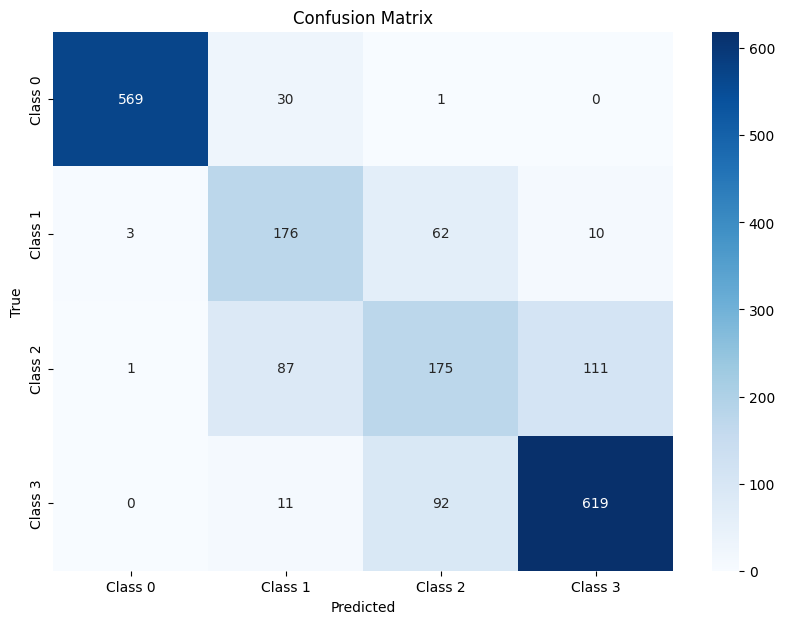

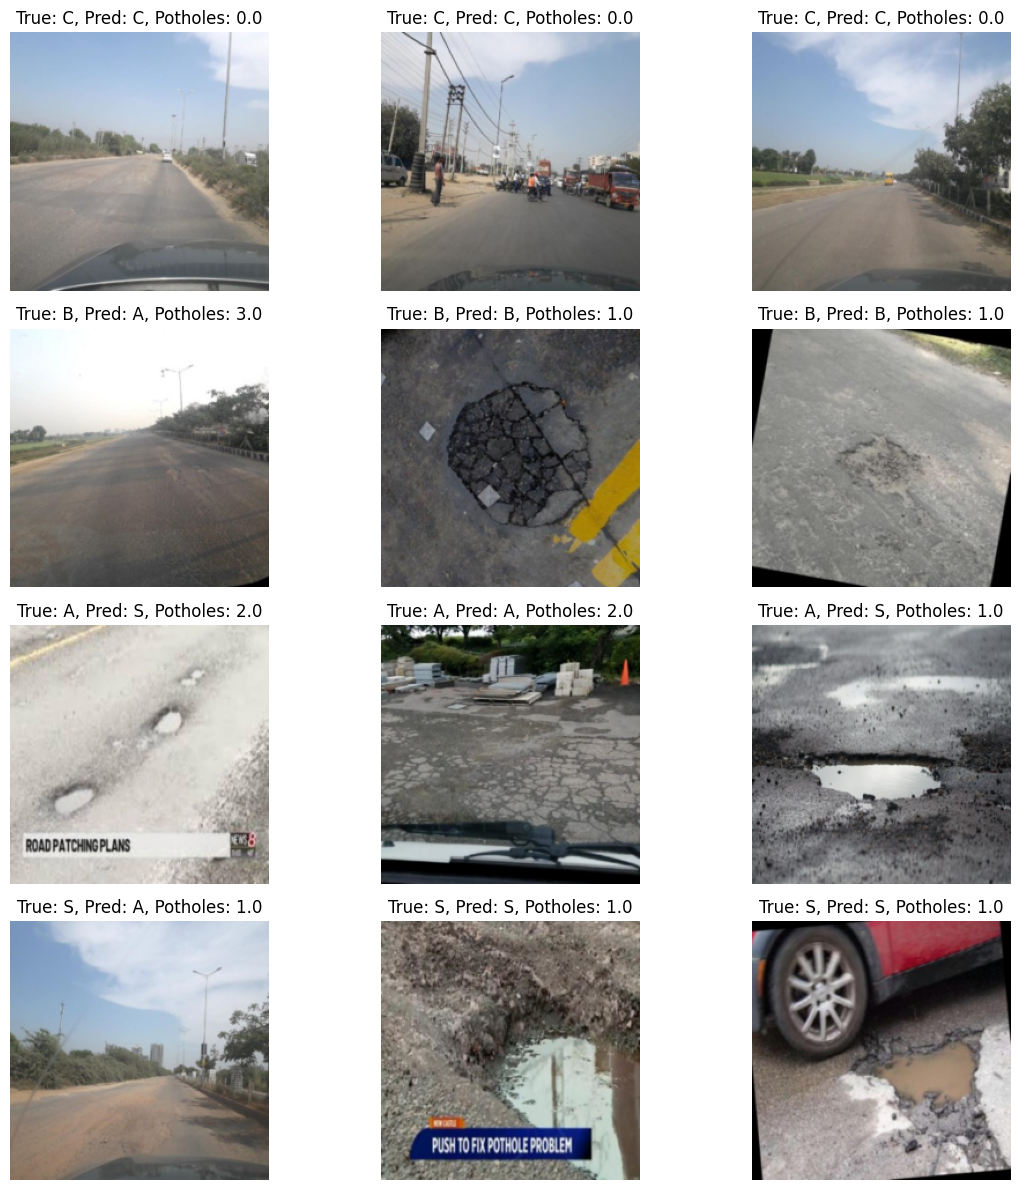

In [11]:
# Initialize lists to store labels and predictions
all_preds = []
all_labels = []

efficientnet_model.eval()
# Evaluate the model
with torch.no_grad():
    for images, metas, labels in test_loader:
        outputs = efficientnet_model(images, metas)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Plot the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(cm.shape[0])], yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Define inverse normalization
inv_normalize = Compose([
    Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
])
# Display two sample images for each label
label_names = ['C', 'B', 'A', 'S']
label_indices = [0, 1, 2, 3]
samples_per_label = 3

# Initialize a dictionary to store sample counts for each label
sample_counts = {label: 0 for label in label_indices}

# Initialize a figure for plotting
fig, axes = plt.subplots(len(label_indices), samples_per_label, figsize=(12, 12))

# Set the model to evaluation mode
efficientnet_model.eval()

# Iterate through the test data
with torch.no_grad():
    sample_plotted = {label: 0 for label in label_indices}
    for images, metas, labels in test_loader:
        if all(count == samples_per_label for count in sample_plotted.values()):
            break
        images, metas, labels = images.to(device), metas.to(device), labels.to(device)
        outputs = efficientnet_model(images, metas)
        _, preds = torch.max(outputs, 1)
        
        for j in range(len(images)):
            true_label = labels[j].item()
            if sample_plotted[true_label] < samples_per_label:
                ax = axes[true_label, sample_plotted[true_label]]
                image = inv_normalize(images[j].cpu())
                image = ToPILImage()(image)
                ax.imshow(image)
                ax.set_title(f"True: {label_names[true_label]}, Pred: {label_names[preds[j].item()]}, Potholes: {metas[j].item()}")
                ax.axis('off')
                sample_plotted[true_label] += 1

# Adjust layout
plt.tight_layout()
plt.show()